<a href="https://colab.research.google.com/github/swilsonmfc/bias_variance/blob/main/FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering

# Install

In [257]:
!pip install featuretools

In [258]:
!pip install catboost

In [259]:
!pip install feature-engine

# Setup
* Restart Kernel

In [260]:
import featuretools as ft
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
import feature_engine as fe

import feature_engine.encoding as ce
import feature_engine.discretisation as dsc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# Data

In [261]:
df = pd.read_csv('https://raw.githubusercontent.com/Featuretools/predict-appointment-noshow/master/data/KaggleV2-May-2016.csv')

In [262]:
df.columns = [col.lower() for col in df.columns]
df = df.rename(columns={'patientid': 'patient_id',
                        'appointmentid': 'appointment_id',
                        'scheduledday': 'scheduled_day',
                        'appointmentday': 'appointment_day',
                        'no-show': 'no_show',
                        'hipertension': 'hypertension',
                        'handcap': 'handicap'})
df['scheduled_day']   = pd.to_datetime(df['scheduled_day']).dt.tz_convert(None)
df['appointment_day'] = pd.to_datetime(df['appointment_day']).dt.tz_convert(None)
df['no_show'] = np.where(df.no_show == 'Yes', 1, 0)

# EDA

## Missing

In [263]:
df.isna().sum()

patient_id         0
appointment_id     0
gender             0
scheduled_day      0
appointment_day    0
age                0
neighbourhood      0
scholarship        0
hypertension       0
diabetes           0
alcoholism         0
handicap           0
sms_received       0
no_show            0
dtype: int64

## Class Balance

In [264]:
WEIGHTS = [len(df) / (2 * sum(np.where(df.no_show == 0, 1, 0))),
           len(df) / (2 * sum(df.no_show))]
print(WEIGHTS)

[0.6265134681661527, 2.4760741968726196]


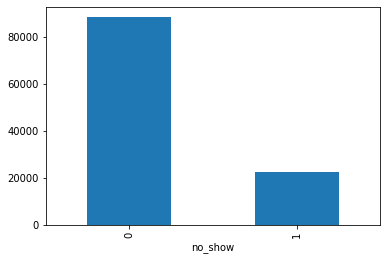

In [265]:
df.groupby('no_show').size().plot.bar()

## Age

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd4510a450>]],
      dtype=object)

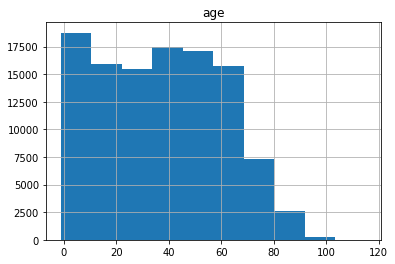

In [266]:
df.hist('age')

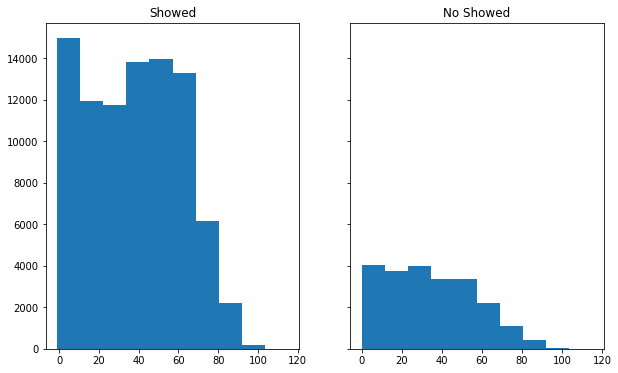

In [267]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,6), sharey=True)
ax[0].hist(df[df.no_show == 0]['age'])
ax[0].set_title('Showed')
ax[1].hist(df[df.no_show == 1]['age'])
ax[1].set_title('No Showed');

## Alcoholics

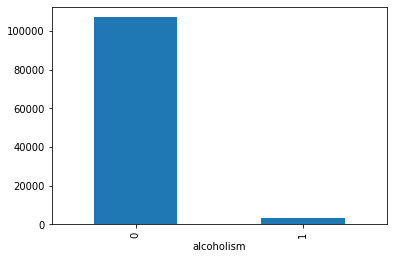

In [268]:
df.groupby('alcoholism').size().plot.bar()

In [269]:
pd.crosstab(df.alcoholism, df.no_show).apply(lambda r: r/r.sum(), axis=1)

no_show,0,1
alcoholism,,
0,0.798054,0.201946
1,0.798512,0.201488


## Handicap

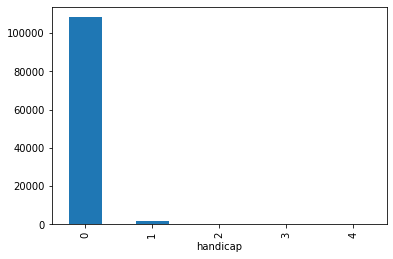

In [270]:
df.groupby('handicap').size().plot.bar()

In [271]:
pd.crosstab(df.handicap, df.no_show).apply(lambda r: r/r.sum(), axis=1)

no_show,0,1
handicap,,
0,0.797647,0.202353
1,0.820764,0.179236
2,0.797814,0.202186
3,0.769231,0.230769
4,0.666667,0.333333


## Gender

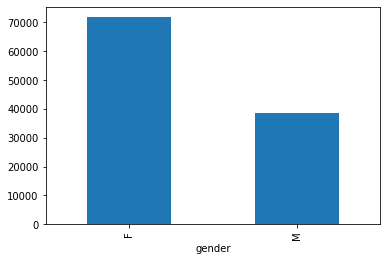

In [272]:
df.groupby('gender').size().plot.bar()

In [273]:
pd.crosstab(df.gender, df.no_show).apply(lambda r: r/r.sum(), axis=1)

no_show,0,1
gender,,
F,0.796854,0.203146
M,0.800321,0.199679


## Scholarship

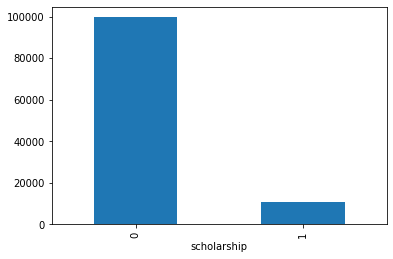

In [274]:
df.groupby('scholarship').size().plot.bar()

In [275]:
pd.crosstab(df.scholarship, df.no_show).apply(lambda r: r/r.sum(), axis=1)

no_show,0,1
scholarship,,
0,0.801928,0.198072
1,0.762637,0.237363


## Hypertension

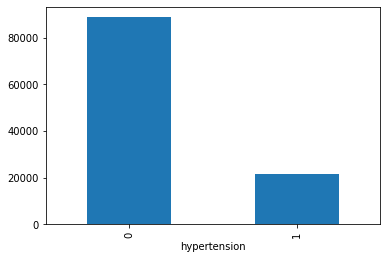

In [276]:
df.groupby('hypertension').size().plot.bar()

In [277]:
pd.crosstab(df.hypertension, df.no_show).apply(lambda r: r/r.sum(), axis=1)

no_show,0,1
hypertension,,
0,0.790963,0.209037
1,0.826980,0.173020


## Diabetes

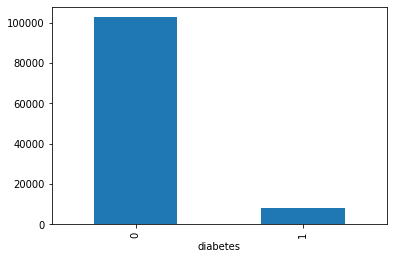

In [278]:
df.groupby('diabetes').size().plot.bar()

In [279]:
pd.crosstab(df.diabetes, df.no_show).apply(lambda r: r/r.sum(), axis=1)

no_show,0,1
diabetes,,
0,0.796372,0.203628
1,0.819967,0.180033


## SMS

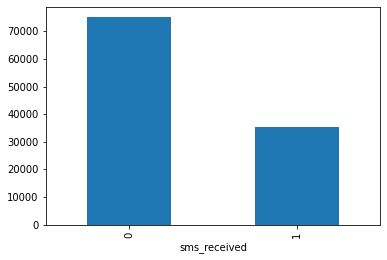

In [280]:
df.groupby('sms_received').size().plot.bar()

In [281]:
pd.crosstab(df.sms_received, df.no_show).apply(lambda r: r/r.sum(), axis=1)

no_show,0,1
sms_received,,
0,0.832967,0.167033
1,0.724255,0.275745


## Neighbourhood

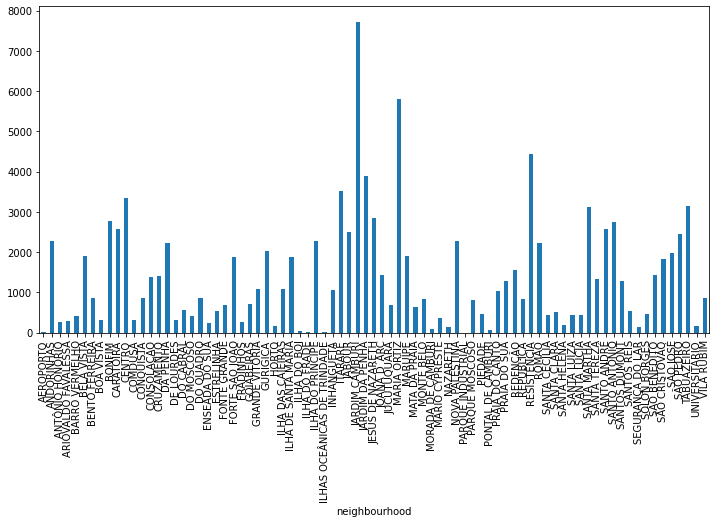

In [282]:
df.groupby('neighbourhood').size().plot.bar(figsize=(12,6))

In [283]:
pd.crosstab(df.neighbourhood, df.no_show).apply(lambda r: r/r.sum(), axis=1).sort_values(1)

no_show,0,1
neighbourhood,,
PARQUE INDUSTRIAL,1.000000,0.000000
ILHA DO BOI,0.914286,0.085714
AEROPORTO,0.875000,0.125000
MÁRIO CYPRESTE,0.854447,0.145553
SOLON BORGES,0.852878,0.147122
...,...,...
ITARARÉ,0.737336,0.262664
SANTA CLARA,0.735178,0.264822
SANTA CECÍLIA,0.725446,0.274554


# Method List
* https://pub.towardsai.net/complete-list-of-feature-engineering-methods-40-techniques-10-categories-fda920883fad

* Encoding
  * One-Hot
  * Label
  * Continuous
* Binarization
* Scaling 
  * Standardization
  * Normalizatioon
  * Log Transformation
* Imputation


# Results

In [284]:
results_df = pd.DataFrame(columns=['Accuracy', 'F1', 'AUC', 'Recall'])

# Baseline

## Categories

In [285]:
CATEGORIES = ['gender',
              'neighbourhood',
              'scholarship',
              'hypertension',
              'diabetes',
              'alcoholism',
              'handicap',
              'sms_received']

In [286]:
X = df.copy()
y = df['no_show']
X = df.drop(columns=['no_show', 'patient_id', 'appointment_id'])

## Train

In [287]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=10)
print(len(X_train), len(X_eval), len(X_test))

74605 8290 27632


In [288]:
model = CatBoostClassifier(cat_features=CATEGORIES, 
                           class_weights=WEIGHTS)
model.fit(X_train, y_train,
          eval_set=(X_eval, y_eval), 
          early_stopping_rounds=5,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.091935
0:	learn: 0.6843458	test: 0.6843178	best: 0.6843178 (0)	total: 85.5ms	remaining: 1m 25s
1:	learn: 0.6763065	test: 0.6764187	best: 0.6764187 (1)	total: 163ms	remaining: 1m 21s
2:	learn: 0.6701559	test: 0.6704733	best: 0.6704733 (2)	total: 236ms	remaining: 1m 18s
3:	learn: 0.6643549	test: 0.6649624	best: 0.6649624 (3)	total: 308ms	remaining: 1m 16s
4:	learn: 0.6595144	test: 0.6602561	best: 0.6602561 (4)	total: 379ms	remaining: 1m 15s
5:	learn: 0.6552313	test: 0.6560063	best: 0.6560063 (5)	total: 458ms	remaining: 1m 15s
6:	learn: 0.6517226	test: 0.6525700	best: 0.6525700 (6)	total: 541ms	remaining: 1m 16s
7:	learn: 0.6489020	test: 0.6497316	best: 0.6497316 (7)	total: 621ms	remaining: 1m 17s
8:	learn: 0.6462131	test: 0.6473025	best: 0.6473025 (8)	total: 695ms	remaining: 1m 16s
9:	learn: 0.6439101	test: 0.6450975	best: 0.6450975 (9)	total: 770ms	remaining: 1m 16s
10:	learn: 0.6420421	test: 0.6434056	best: 0.6434056 (10)	total: 860ms	remaining: 1m 17s
11:	learn:

## Predict

In [289]:
preds = model.predict(X_test)
probs = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, preds)
f1       = f1_score(y_test, preds)
roc      = roc_auc_score(y_test, probs[:,1])
recall   = recall_score(y_test, preds)
results_df.loc['Baseline'] = [accuracy, f1, roc, recall]

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.90      0.60      0.72     22130
           1       0.31      0.73      0.44      5502

    accuracy                           0.63     27632
   macro avg       0.61      0.67      0.58     27632
weighted avg       0.78      0.63      0.66     27632



## Importance

In [290]:
imp  = model.feature_importances_
feat = model.feature_names_
pd.DataFrame({'Feature' : feat, 'Importance': imp}).sort_values('Importance', ascending=False)

,Feature,Importance
1,scheduled_day,39.378920
2,appointment_day,29.569293
3,age,9.855654
10,sms_received,9.485579
4,neighbourhood,6.213779
0,gender,1.366170
9,handicap,1.346324
8,alcoholism,1.130176
5,scholarship,0.742256
7,diabetes,0.513345


# Feature Engine
![](https://feature-engine.readthedocs.io/en/1.0.x/_images/FeatureEngine.png)

## Capabilities
* Missing Data
* Categorical Variables
* Variable Transformations
* Discretization
* Outliers
* Feature Creation
* Feature Selection
* https://www.packtpub.com/product/python-feature-engineering-cookbook/9781789806311

## Categories

In [291]:
CATEGORIES = ['gender',
              'neighbourhood',
              'scholarship',
              'hypertension',
              'diabetes',
              'alcoholism',
              'handicap',
              'sms_received']

In [292]:
X = df.copy()
y = df['no_show']
X = df.drop(columns=['no_show', 'patient_id', 'appointment_id'])

In [293]:
# Feature Engine looks for object types
# Can't handle categories (seems like a possible place to make a PR)
for cat in CATEGORIES:
  X[cat] = X[cat].astype('object')
X.dtypes

gender                     object
scheduled_day      datetime64[ns]
appointment_day    datetime64[ns]
age                         int64
neighbourhood              object
scholarship                object
hypertension               object
diabetes                   object
alcoholism                 object
handicap                   object
sms_received               object
dtype: object

## Split

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=10)
print(len(X_train), len(X_eval), len(X_test))

74605 8290 27632


## Mean Encoding
* Replace OHE / Label encoding with continuous value
* Replacement takes mean of label grouped by category
* Library has several encoders and follows scikit
  * OneHot
  * CountFreq
  * Ordinal
  * Mean
  * Weight of Evidence
  * PRatio
  * DecisionTree
  * RareLabel

In [295]:
encode = CATEGORIES
encoder_mean = ce.MeanEncoder(variables=encode)
encoder_mean.fit(X_train, y_train)
X_train = encoder_mean.transform(X_train)
X_eval  = encoder_mean.transform(X_eval)
X_test  = encoder_mean.transform(X_test)

In [296]:
X_train.dtypes

gender                    float64
scheduled_day      datetime64[ns]
appointment_day    datetime64[ns]
age                         int64
neighbourhood             float64
scholarship               float64
hypertension              float64
diabetes                  float64
alcoholism                float64
handicap                  float64
sms_received              float64
dtype: object

## Dates & Times

In [297]:
for frame in [X_train, X_eval, X_test]:
  frame['scheduled_year']  = frame.scheduled_day.dt.year 
  frame['scheduled_month'] = frame.scheduled_day.dt.month 
  frame['scheduled_dom']   = frame.scheduled_day.dt.day
  frame['scheduled_dow']   = frame.scheduled_day.dt.day_of_week
  frame['scheduled_hour']  = frame.scheduled_day.dt.hour
  
  frame['appointment_year']  = frame.appointment_day.dt.year 
  frame['appointment_month'] = frame.appointment_day.dt.month 
  frame['appointment_dom']   = frame.appointment_day.dt.day
  frame['appointment_dow']   = frame.appointment_day.dt.day_of_week
  frame['appointment_hour']  = frame.appointment_day.dt.hour

  frame.pop('scheduled_day')
  frame.pop('appointment_day')

## Train

In [298]:
model = CatBoostClassifier(class_weights=WEIGHTS)
model.fit(X_train, y_train,
          eval_set=(X_eval, y_eval), 
          early_stopping_rounds=5,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.091935
0:	learn: 0.6857052	test: 0.6859597	best: 0.6859597 (0)	total: 31.6ms	remaining: 31.6s
1:	learn: 0.6772180	test: 0.6775525	best: 0.6775525 (1)	total: 64.5ms	remaining: 32.2s
2:	learn: 0.6716679	test: 0.6724493	best: 0.6724493 (2)	total: 93.3ms	remaining: 31s
3:	learn: 0.6668634	test: 0.6679889	best: 0.6679889 (3)	total: 123ms	remaining: 30.6s
4:	learn: 0.6625736	test: 0.6638760	best: 0.6638760 (4)	total: 152ms	remaining: 30.2s
5:	learn: 0.6572730	test: 0.6586509	best: 0.6586509 (5)	total: 181ms	remaining: 29.9s
6:	learn: 0.6540511	test: 0.6553327	best: 0.6553327 (6)	total: 216ms	remaining: 30.7s
7:	learn: 0.6504196	test: 0.6517485	best: 0.6517485 (7)	total: 261ms	remaining: 32.4s
8:	learn: 0.6484918	test: 0.6498392	best: 0.6498392 (8)	total: 290ms	remaining: 31.9s
9:	learn: 0.6460482	test: 0.6475160	best: 0.6475160 (9)	total: 323ms	remaining: 32s
10:	learn: 0.6433932	test: 0.6450973	best: 0.6450973 (10)	total: 373ms	remaining: 33.5s
11:	learn: 0.6420996	te

## Predict

In [299]:
preds = model.predict(X_test)
probs = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, preds)
f1       = f1_score(y_test, preds)
roc      = roc_auc_score(y_test, probs[:,1])
recall   = recall_score(y_test, preds)
results_df.loc['Feature Engine'] = [accuracy, f1, roc, recall]

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.90      0.59      0.71     22130
           1       0.31      0.74      0.44      5502

    accuracy                           0.62     27632
   macro avg       0.60      0.66      0.57     27632
weighted avg       0.78      0.62      0.66     27632



## Importance

In [300]:
imp  = model.feature_importances_
feat = model.feature_names_
pd.DataFrame({'Feature' : feat, 'Importance': imp}).sort_values('Importance', ascending=False)

,Feature,Importance
10,scheduled_month,14.967606
11,scheduled_dom,13.114726
16,appointment_dom,13.105534
12,scheduled_dow,12.272580
17,appointment_dow,12.170666
8,sms_received,10.046590
1,age,8.239951
2,neighbourhood,4.688702
13,scheduled_hour,4.438435
15,appointment_month,2.640784


# FeatureTools

![](https://featuretools.alteryx.com/en/stable/_images/featuretools_nav2.svg)

## Variables

In [301]:
vars = {'gender': ft.variable_types.Categorical,
        'patient_id': ft.variable_types.Categorical,
        'age': ft.variable_types.Ordinal,
        'scholarship': ft.variable_types.Boolean,
        'hypertension': ft.variable_types.Boolean,
        'diabetes': ft.variable_types.Boolean,
        'alcoholism': ft.variable_types.Boolean,
        'handicap': ft.variable_types.Boolean,
        'no_show': ft.variable_types.Boolean,
        'sms_received': ft.variable_types.Boolean}

## EntitySet

In [302]:
es = ft.EntitySet('Appointments')
es = es.entity_from_dataframe(entity_id = 'appointments',
                              dataframe=df,
                              index='appointment_id',
                              time_index='scheduled_day',
                              secondary_time_index={'appointment_day': ['no_show', 'sms_received']},
                              variable_types = vars)
es['appointments']

Entity: appointments
  Variables:
    appointment_id (dtype: index)
    scheduled_day (dtype: datetime_time_index)
    appointment_day (dtype: datetime)
    neighbourhood (dtype: categorical)
    gender (dtype: categorical)
    patient_id (dtype: categorical)
    age (dtype: ordinal)
    scholarship (dtype: boolean)
    hypertension (dtype: boolean)
    diabetes (dtype: boolean)
    alcoholism (dtype: boolean)
    handicap (dtype: boolean)
    no_show (dtype: boolean)
    sms_received (dtype: boolean)
  Shape:
    (Rows: 110527, Columns: 14)

## Relationships

In [303]:
es.normalize_entity('appointments', 'patients', 'patient_id',
                    additional_variables=['scholarship',
                                          'hypertension',
                                          'diabetes',
                                          'alcoholism',
                                          'handicap'])

es.normalize_entity('appointments', 'locations', 'neighbourhood', make_time_index=False)
es.normalize_entity('appointments', 'ages', 'age',                make_time_index=False)
es.normalize_entity('appointments', 'genders', 'gender',          make_time_index=False)

Entityset: Appointments
  Entities:
    appointments [Rows: 110527, Columns: 9]
    patients [Rows: 62299, Columns: 7]
    locations [Rows: 81, Columns: 1]
    ages [Rows: 104, Columns: 1]
    genders [Rows: 2, Columns: 1]
  Relationships:
    appointments.patient_id -> patients.patient_id
    appointments.neighbourhood -> locations.neighbourhood
    appointments.age -> ages.age
    appointments.gender -> genders.gender

In [304]:
es

Entityset: Appointments
  Entities:
    appointments [Rows: 110527, Columns: 9]
    patients [Rows: 62299, Columns: 7]
    locations [Rows: 81, Columns: 1]
    ages [Rows: 104, Columns: 1]
    genders [Rows: 2, Columns: 1]
  Relationships:
    appointments.patient_id -> patients.patient_id
    appointments.neighbourhood -> locations.neighbourhood
    appointments.age -> ages.age
    appointments.gender -> genders.gender

In [305]:
es['patients'].df.head(2)

,patient_id,scholarship,hypertension,diabetes,alcoholism,handicap,first_appointments_time
8.322564e+14,8.322564e+14,0,0,0,0,0,2015-11-10 07:13:56
9.163747e+13,9.163747e+13,0,1,0,0,0,2015-12-03 08:17:28


## Visualize

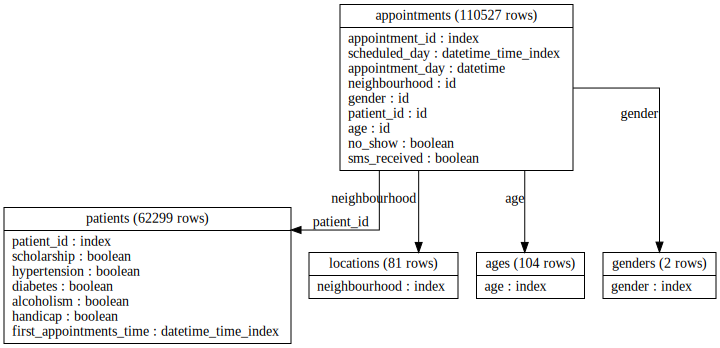

In [306]:
es.plot()

## Cutoffs

In [307]:
cutoff_df = es['appointments'].df[['appointment_id', 'scheduled_day', 'no_show']].sort_values(by='scheduled_day')
cutoff_df = cutoff_df.rename(columns={'scheduled_day': 'time', 'no_show': 'label'})
cutoff_df.head()

,appointment_id,time,label
5030230,5030230,2015-11-10 07:13:56,0
5122866,5122866,2015-12-03 08:17:28,1
5134197,5134197,2015-12-07 10:40:59,1
5134220,5134220,2015-12-07 10:42:42,0
5134223,5134223,2015-12-07 10:43:01,0


In [308]:
cutoff_df.dtypes

appointment_id             int64
time              datetime64[ns]
label                      int64
dtype: object

## Deep Feature Synthesis

In [309]:
fm, features = ft.dfs(entityset = es,
                      target_entity = 'appointments',
                      agg_primitives = ['count', 'percent_true'],
                      trans_primitives = ['is_weekend', 'weekday', 'day', 'month', 'year'],
                      max_depth=3,
                      approximate='6h',
                      cutoff_time=cutoff_df[20000:],
                      verbose=True)

Built 46 features
Elapsed: 01:18 | Progress: 100%|██████████


In [310]:
fm.head()

,neighbourhood,gender,patient_id,age,no_show,sms_received,DAY(appointment_day),DAY(scheduled_day),IS_WEEKEND(appointment_day),IS_WEEKEND(scheduled_day),MONTH(appointment_day),MONTH(scheduled_day),WEEKDAY(appointment_day),WEEKDAY(scheduled_day),YEAR(appointment_day),YEAR(scheduled_day),patients.scholarship,patients.hypertension,patients.diabetes,patients.alcoholism,patients.handicap,patients.COUNT(appointments),patients.PERCENT_TRUE(appointments.no_show),patients.PERCENT_TRUE(appointments.sms_received),patients.DAY(first_appointments_time),patients.IS_WEEKEND(first_appointments_time),patients.MONTH(first_appointments_time),patients.WEEKDAY(first_appointments_time),patients.YEAR(first_appointments_time),locations.COUNT(appointments),locations.PERCENT_TRUE(appointments.no_show),locations.PERCENT_TRUE(appointments.sms_received),ages.COUNT(appointments),ages.PERCENT_TRUE(appointments.no_show),ages.PERCENT_TRUE(appointments.sms_received),genders.COUNT(appointments),genders.PERCENT_TRUE(appointments.no_show),genders.PERCENT_TRUE(appointments.sms_received),patients.PERCENT_TRUE(appointments.IS_WEEKEND(appointment_day)),patients.PERCENT_TRUE(appointments.IS_WEEKEND(scheduled_day)),locations.PERCENT_TRUE(appointments.IS_WEEKEND(appointment_day)),locations.PERCENT_TRUE(appointments.IS_WEEKEND(scheduled_day)),ages.PERCENT_TRUE(appointments.IS_WEEKEND(appointment_day)),ages.PERCENT_TRUE(appointments.IS_WEEKEND(scheduled_day)),genders.PERCENT_TRUE(appointments.IS_WEEKEND(appointment_day)),genders.PERCENT_TRUE(appointments.IS_WEEKEND(scheduled_day)),label
appointment_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5623805,SANTA MARTHA,F,4.532923e+10,18,0.0,1.0,31,26,False,False,5,4,1,1,2016,2016,0,0,0,0,0,0,0.0,0.0,26,False,4,1,2016,457.0,0.0,0.0,212.0,0.0,0.0,13105,0.0,0.0,0.0,0.0,0.0,0.002188,0.0,0.0,0.0,0.000305,0
5623811,SANTA MARTHA,M,7.756472e+12,27,0.0,1.0,5,26,False,False,5,4,3,1,2016,2016,0,1,0,0,0,0,0.0,0.0,26,False,4,1,2016,457.0,0.0,0.0,223.0,0.0,0.0,6438,0.0,0.0,0.0,0.0,0.0,0.002188,0.0,0.0,0.0,0.000000,0
5623814,JARDIM CAMBURI,M,7.267524e+12,20,0.0,1.0,11,26,False,False,5,4,2,1,2016,2016,0,0,0,0,0,0,0.0,0.0,26,False,4,1,2016,2272.0,0.0,0.0,249.0,0.0,0.0,6438,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0
5623815,SANTO ANTÔNIO,F,7.762846e+13,33,0.0,0.0,16,26,False,False,5,4,0,1,2016,2016,0,0,0,0,0,0,0.0,0.0,26,False,4,1,2016,279.0,0.0,0.0,296.0,0.0,0.0,13105,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000305,0
5623817,REPÚBLICA,F,2.986375e+12,74,0.0,1.0,5,26,False,False,5,4,3,1,2016,2016,0,0,0,0,0,0,0.0,0.0,26,False,4,1,2016,61.0,0.0,0.0,129.0,0.0,0.0,13105,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000305,0


In [311]:
features

[<Feature: neighbourhood>,
 <Feature: gender>,
 <Feature: patient_id>,
 <Feature: age>,
 <Feature: no_show>,
 <Feature: sms_received>,
 <Feature: DAY(appointment_day)>,
 <Feature: DAY(scheduled_day)>,
 <Feature: IS_WEEKEND(appointment_day)>,
 <Feature: IS_WEEKEND(scheduled_day)>,
 <Feature: MONTH(appointment_day)>,
 <Feature: MONTH(scheduled_day)>,
 <Feature: WEEKDAY(appointment_day)>,
 <Feature: WEEKDAY(scheduled_day)>,
 <Feature: YEAR(appointment_day)>,
 <Feature: YEAR(scheduled_day)>,
 <Feature: patients.scholarship>,
 <Feature: patients.hypertension>,
 <Feature: patients.diabetes>,
 <Feature: patients.alcoholism>,
 <Feature: patients.handicap>,
 <Feature: patients.COUNT(appointments)>,
 <Feature: patients.PERCENT_TRUE(appointments.no_show)>,
 <Feature: patients.PERCENT_TRUE(appointments.sms_received)>,
 <Feature: patients.DAY(first_appointments_time)>,
 <Feature: patients.IS_WEEKEND(first_appointments_time)>,
 <Feature: patients.MONTH(first_appointments_time)>,
 <Feature: patients.

## Split

In [312]:
cols = [c for c in fm.columns if c != 'no_show']
fm = fm[cols]
X = fm.copy()
y = X.pop('label')
X = X.drop(columns=['patient_id', 'neighbourhood', 'gender'])

In [313]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=10)
print(len(X_train), len(X_eval), len(X_test))

61105 6790 22632


## Train

In [314]:
model = CatBoostClassifier(class_weights=WEIGHTS)
model.fit(X_train, y_train,
          eval_set=(X_eval, y_eval), 
          early_stopping_rounds=5,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.087512
0:	learn: 0.6837954	test: 0.6841531	best: 0.6841531 (0)	total: 39.8ms	remaining: 39.7s
1:	learn: 0.6752631	test: 0.6761778	best: 0.6761778 (1)	total: 81.1ms	remaining: 40.5s
2:	learn: 0.6684166	test: 0.6697954	best: 0.6697954 (2)	total: 127ms	remaining: 42.1s
3:	learn: 0.6639635	test: 0.6656142	best: 0.6656142 (3)	total: 162ms	remaining: 40.3s
4:	learn: 0.6588096	test: 0.6608069	best: 0.6608069 (4)	total: 210ms	remaining: 41.8s
5:	learn: 0.6539737	test: 0.6561996	best: 0.6561996 (5)	total: 243ms	remaining: 40.3s
6:	learn: 0.6499737	test: 0.6526086	best: 0.6526086 (6)	total: 300ms	remaining: 42.5s
7:	learn: 0.6466790	test: 0.6492973	best: 0.6492973 (7)	total: 336ms	remaining: 41.7s
8:	learn: 0.6439374	test: 0.6469768	best: 0.6469768 (8)	total: 377ms	remaining: 41.6s
9:	learn: 0.6412860	test: 0.6444582	best: 0.6444582 (9)	total: 423ms	remaining: 41.8s
10:	learn: 0.6387359	test: 0.6418169	best: 0.6418169 (10)	total: 464ms	remaining: 41.7s
11:	learn: 0.6366254

## Predict

In [315]:
preds = model.predict(X_test)
probs = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, preds)
f1       = f1_score(y_test, preds)
roc      = roc_auc_score(y_test, probs[:,1])
recall   = recall_score(y_test, preds)
results_df.loc['FeatureTools'] = [accuracy, f1, roc, recall]

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.90      0.68      0.77     18689
           1       0.30      0.66      0.42      3943

    accuracy                           0.68     22632
   macro avg       0.60      0.67      0.60     22632
weighted avg       0.80      0.68      0.71     22632



## Importance

In [316]:
imp  = model.feature_importances_
feat = model.feature_names_
pd.DataFrame({'Feature' : feat, 'Importance': imp}).sort_values('Importance', ascending=False)

,Feature,Importance
2,DAY(appointment_day),16.132420
1,sms_received,10.445664
8,WEEKDAY(appointment_day),9.757551
3,DAY(scheduled_day),9.061149
9,WEEKDAY(scheduled_day),8.864913
32,genders.PERCENT_TRUE(appointments.no_show),6.396565
0,age,5.654592
18,patients.PERCENT_TRUE(appointments.no_show),3.961243
6,MONTH(appointment_day),3.574657
17,patients.COUNT(appointments),3.436049


# Compare

In [317]:
results_df.sort_values('Recall', ascending=False)

,Accuracy,F1,AUC,Recall
Feature Engine,0.618920,0.435812,0.728316,0.739186
Baseline,0.625470,0.438012,0.727363,0.733006
FeatureTools,0.675018,0.415202,0.743083,0.662186


# Extended
* Ideas for additional engineering?
* Feature Tools
  * Weekends not helpful 
* Other feature engineering?
  * Combine rare neighborhoods
  * Alternative Treatments
* Add / Subtract / Multiply / Divide
  * Far In Advance


## Categories

In [333]:
CATEGORIES = ['gender',
              'neighbourhood',
              'scholarship',
              'hypertension',
              'diabetes',
              'alcoholism',
              'handicap',
              'sms_received']

In [334]:
X = df.copy()
y = df['no_show']
X = df.drop(columns=['no_show', 'patient_id', 'appointment_id'])

In [335]:
# Feature Engine looks for object types
# Can't handle categories (seems like a possible place to make a PR)
for cat in CATEGORIES:
  X[cat] = X[cat].astype('object')
X.dtypes

gender                     object
scheduled_day      datetime64[ns]
appointment_day    datetime64[ns]
age                         int64
neighbourhood              object
scholarship                object
hypertension               object
diabetes                   object
alcoholism                 object
handicap                   object
sms_received               object
dtype: object

## Split

In [336]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=10)
print(len(X_train), len(X_eval), len(X_test))

74605 8290 27632


## Rare Neighborhoods

In [337]:
encoder = ce.RareLabelEncoder(tol=0.01, n_categories=30, variables=['neighbourhood'])
encoder.fit(X_train)
X_train = encoder.transform(X_train)
X_train = encoder.transform(X_train)
X_eval  = encoder.transform(X_eval)
X_test  = encoder.transform(X_test)

In [338]:
X_train.groupby('neighbourhood').size()

neighbourhood
ANDORINHAS              1542
BELA VISTA              1272
BONFIM                  1895
CARATOÍRA               1724
CENTRO                  2239
CONSOLAÇÃO               916
CRUZAMENTO               945
DA PENHA                1468
FORTE SÃO JOÃO          1276
GURIGICA                1371
ILHA DE SANTA MARIA     1244
ILHA DO PRÍNCIPE        1509
ITARARÉ                 2375
JABOUR                  1689
JARDIM CAMBURI          5185
JARDIM DA PENHA         2644
JESUS DE NAZARETH       1931
JOANA D´ARC              977
MARIA ORTIZ             3889
MARUÍPE                 1239
NOVA PALESTINA          1561
PRAIA DO SUÁ             869
REDENÇÃO                1045
RESISTÊNCIA             3024
ROMÃO                   1526
Rare                   14429
SANTA MARTHA            2163
SANTA TEREZA             882
SANTO ANDRÉ             1723
SANTO ANTÔNIO           1879
SANTOS DUMONT            857
SÃO BENEDITO             968
SÃO CRISTÓVÃO           1239
SÃO JOSÉ                1294


## PRatio Encoding
* P(1) / P(0)
* log(P(1) / P(0))


In [339]:
encode = CATEGORIES
encoder = ce.PRatioEncoder(variables=encode, encoding_method='log_ratio')
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)
X_eval  = encoder.transform(X_eval)
X_test  = encoder.transform(X_test)

In [340]:
X_train.dtypes

gender                    float64
scheduled_day      datetime64[ns]
appointment_day    datetime64[ns]
age                         int64
neighbourhood             float64
scholarship               float64
hypertension              float64
diabetes                  float64
alcoholism                float64
handicap                  float64
sms_received              float64
dtype: object

## Advance

In [342]:
for frame in [X_train, X_eval, X_test]:
  frame['advance'] = frame.appointment_day - frame.scheduled_day

## Dates & Times

In [343]:
for frame in [X_train, X_eval, X_test]:
  frame['scheduled_year']  = frame.scheduled_day.dt.year 
  frame['scheduled_month'] = frame.scheduled_day.dt.month 
  frame['scheduled_dom']   = frame.scheduled_day.dt.day
  frame['scheduled_dow']   = frame.scheduled_day.dt.day_of_week
  frame['scheduled_hour']  = frame.scheduled_day.dt.hour
  
  frame['appointment_year']  = frame.appointment_day.dt.year 
  frame['appointment_month'] = frame.appointment_day.dt.month 
  frame['appointment_dom']   = frame.appointment_day.dt.day
  frame['appointment_dow']   = frame.appointment_day.dt.day_of_week
  frame['appointment_hour']  = frame.appointment_day.dt.hour

  frame.pop('scheduled_day')
  frame.pop('appointment_day')

## Train

In [344]:
model = CatBoostClassifier(class_weights=WEIGHTS)
model.fit(X_train, y_train,
          eval_set=(X_eval, y_eval), 
          early_stopping_rounds=5,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.091935
0:	learn: 0.6754394	test: 0.6751103	best: 0.6751103 (0)	total: 30.6ms	remaining: 30.6s
1:	learn: 0.6613844	test: 0.6607935	best: 0.6607935 (1)	total: 73.3ms	remaining: 36.6s
2:	learn: 0.6502371	test: 0.6492904	best: 0.6492904 (2)	total: 107ms	remaining: 35.4s
3:	learn: 0.6407526	test: 0.6394225	best: 0.6394225 (3)	total: 146ms	remaining: 36.4s
4:	learn: 0.6329813	test: 0.6312792	best: 0.6312792 (4)	total: 176ms	remaining: 35s
5:	learn: 0.6269197	test: 0.6250121	best: 0.6250121 (5)	total: 214ms	remaining: 35.4s
6:	learn: 0.6217212	test: 0.6195527	best: 0.6195527 (6)	total: 247ms	remaining: 35.1s
7:	learn: 0.6175372	test: 0.6152153	best: 0.6152153 (7)	total: 280ms	remaining: 34.8s
8:	learn: 0.6138592	test: 0.6112627	best: 0.6112627 (8)	total: 317ms	remaining: 34.9s
9:	learn: 0.6108328	test: 0.6081332	best: 0.6081332 (9)	total: 354ms	remaining: 35.1s
10:	learn: 0.6086435	test: 0.6057845	best: 0.6057845 (10)	total: 395ms	remaining: 35.5s
11:	learn: 0.6065373	t

## Predict

In [345]:
preds = model.predict(X_test)
probs = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, preds)
f1       = f1_score(y_test, preds)
roc      = roc_auc_score(y_test, probs[:,1])
recall   = recall_score(y_test, preds)
results_df.loc['Extended'] = [accuracy, f1, roc, recall]

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.53      0.68     22130
           1       0.31      0.82      0.45      5502

    accuracy                           0.59     27632
   macro avg       0.61      0.68      0.56     27632
weighted avg       0.80      0.59      0.63     27632



## Importance

In [346]:
imp  = model.feature_importances_
feat = model.feature_names_
pd.DataFrame({'Feature' : feat, 'Importance': imp}).sort_values('Importance', ascending=False)

,Feature,Importance
9,advance,49.713992
1,age,14.934832
2,neighbourhood,6.977910
14,scheduled_hour,5.432110
13,scheduled_dow,3.427583
18,appointment_dow,3.179294
12,scheduled_dom,3.008961
17,appointment_dom,2.768593
0,gender,1.979636
11,scheduled_month,1.977681


## Compare
* Accuracy Down
* Recall Up

In [347]:
results_df.sort_values('Recall', ascending=False)

,Accuracy,F1,AUC,Recall
Extended,0.592031,0.445799,0.737707,0.824064
Feature Engine,0.618920,0.435812,0.728316,0.739186
Baseline,0.625470,0.438012,0.727363,0.733006
FeatureTools,0.675018,0.415202,0.743083,0.662186
